# Modelo previctivo de supervivencia del Titanic


El objetivo de este trabajo es buscar predecir que pasajero sobrevivio el hundimiento del Titanic. El mismo corresponde a una competencia abierta en kaggle donde se bridan dos datasets. Los mismos son el "train.csv" y "test.csv" usadas para el entrenamiento del modelo de machine learning a definir y el testeo del mismo respectivamente.

La estructura de los datos contenidos en ambos data frames es:


- survival: sobrevivo al accidente? 1:si, 0:No
- pclass: Clase en la que abordo, 1 (primera clase), 2 (segunda clase), 3 (tercera clase)
- sex	: Sexo de la persona
- Age	: Edad en años
- sibsp	: Numero de hermanos presentes
- parch	: Numero de padres/hijos abordo ( si habia padres solos o parejas)
- ticket: Numero de Ticket
- fare:	Costo del pasaje que abono
- cabin:	Numero de cabina
- embarked:	Puerto donde embarco

### Hipotesis a probar

La hipotesis inicial es que la franaja poblacional con mayor probabilidad de supervivencia fue la de mujeres de primera clase, tambien se busca identificar que variables van a influir sobre la probabilidad de sobrevivir el hundimietno.


In [288]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
!pip install xgboost

plt.style.use('fivethirtyeight')

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [289]:
df= pd.read_csv("train.csv")
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [290]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Solo 3 columnas contienen datos nulos siendo la columna "edad" la que mayores registros nulos tiene. Esto puede ser debido a que eran bebes o incluso hbain nacido durante el viaje y su edad no habia sido registrada.

## Evaluo la tasa de supervivencia dentro del dataset train:

In [291]:
a=df["Survived"].value_counts()
a

Survived
0    549
1    342
Name: count, dtype: int64

## Numero de pasajeros totales en este set:

In [292]:
df["Survived"].count()

891

## Grafico la tasa de supervivencia de mi dataset train:

Busco ver cuantas personas no sobrevivieron del total de las personas presentes en el dataset

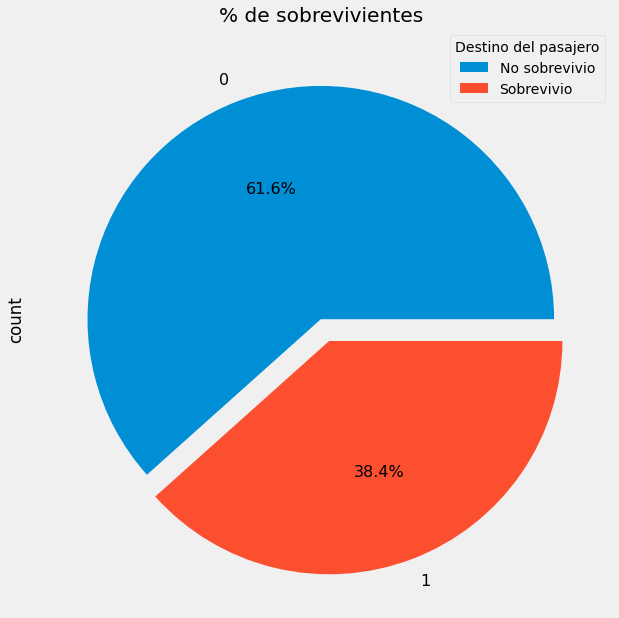

In [435]:
f,ax=plt.subplots(figsize=(18,10))
a.plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax,textprops={'fontsize': 16})
index = ["No sobrevivio", "Sobrevivio"]
plt.title('% de sobrevivientes')
plt.legend(index, title='Destino del pasajero', loc='best')



De un total de 891 individuos presentes en el data set, puede verse que solo un 61,6% de los pasajeros sobrevivio mientras que el 38,4% de los mismos no lo hizo

## Distribucion de Hombres vs mujeres en el barco:

Busco ver como era la relacion entre hombres y mujeres en el barco y si el sexo de una persona pudo haber influido en la tasa de superviviencia de la misma o simplemente   una mayor frecuencia de alguno de los generos puede influenciar en la conclusion.

In [294]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [295]:
b=df["Sex"].value_counts()
c=df["Sex"].count()
b

Sex
male      577
female    314
Name: count, dtype: int64

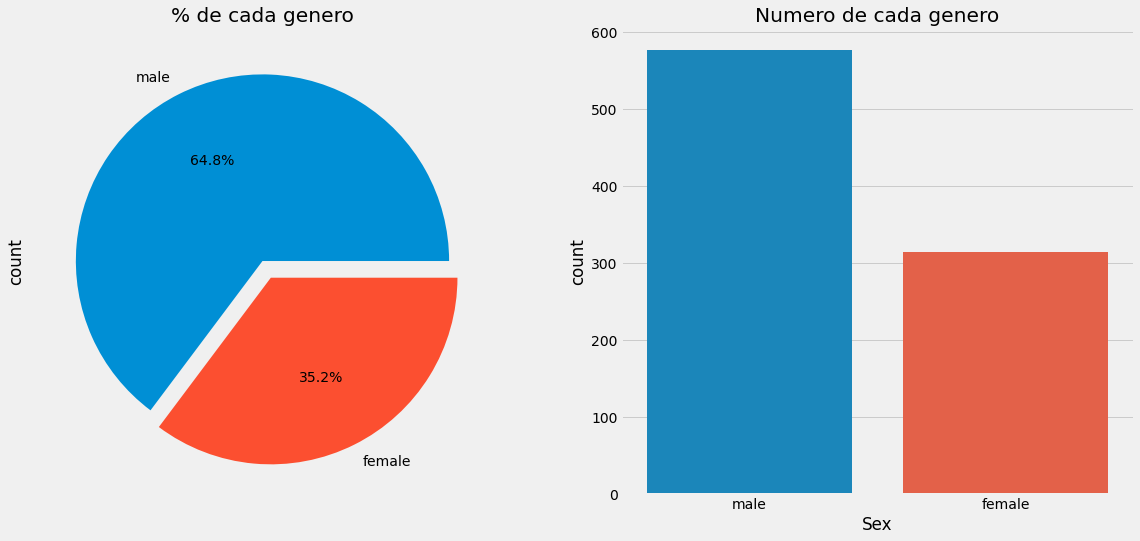

In [296]:
f,ax=plt.subplots(1,2,figsize=(18,8))
b.plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('% de cada genero')

sns.countplot(x=df["Sex"],ax=ax[1])
ax[1].set_title('Numero de cada genero')
plt.show()

Podemos ver que habia muchos mas hombres que mujeres en el barco. Paso a analizar como se relaciona el genero con la tasa de supervivencia.

In [297]:
d=df.groupby(["Sex","Survived"])["Survived"].count()
d

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

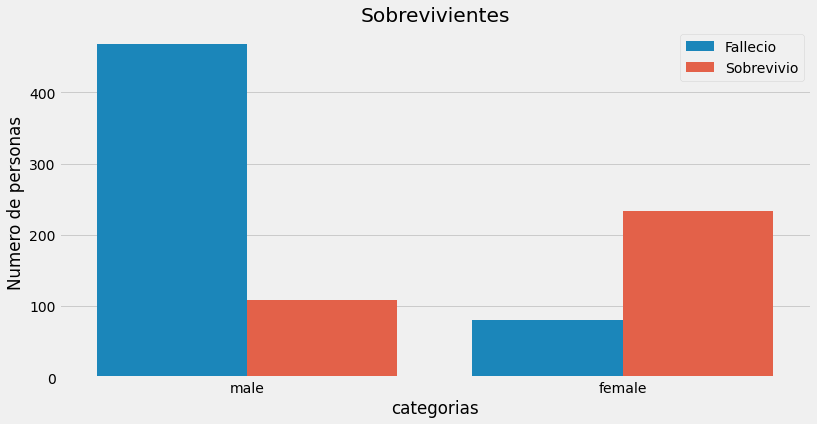

In [298]:
f,ax=plt.subplots(figsize=(12,6))
sns.countplot(x=df["Sex"],hue=df['Survived'])
ax.set_title('Sobrevivientes')
ax.set_ylabel('Numero de personas')
ax.set_xlabel('categorias')
plt.legend(labels = ['Fallecio', 'Sobrevivio'])

plt.show()

Puede verse que pese a haber muchos mas hombres a bordo del barco, la tasa de supervivencia de los mismos fue considerablemente menor que el de las mujeres

## Supervivencia/Clase

Analizo las diferencias en la tasa de supervivencia dependiendo de la clase en la que iban a bondo y como esta variable se relaciona con las otras previamente analizadas (sexo)

In [299]:
df[["Survived", "Pclass"]].groupby(by=("Pclass")).count()

,Survived
Pclass,
1,216
2,184
3,491


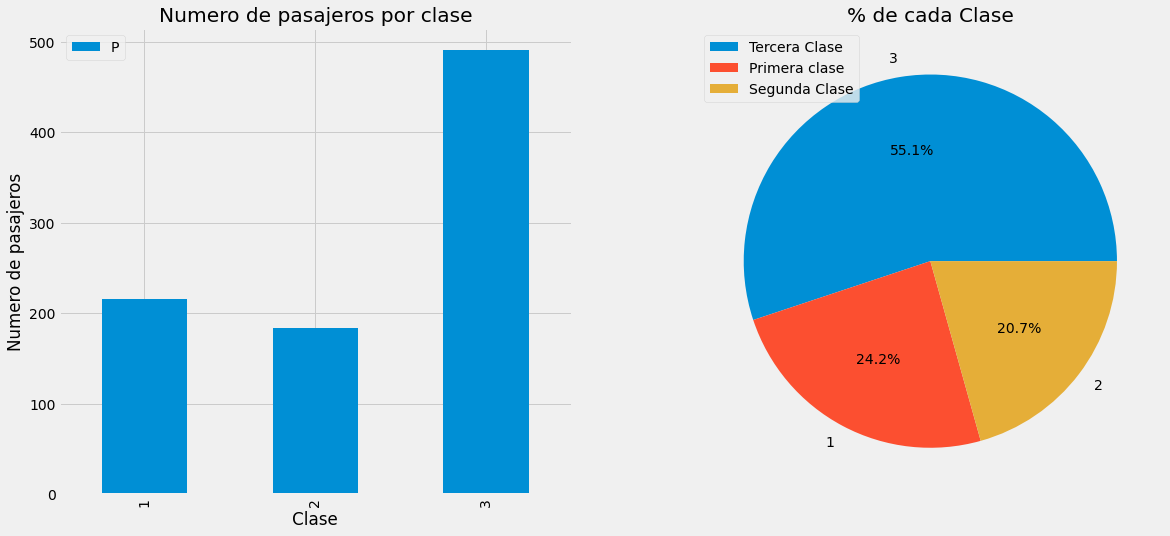

In [300]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df[["Survived", "Pclass"]].groupby(by=("Pclass")).count().plot.bar(ax=ax[0])
ax[0].set_title('Numero de pasajeros por clase')
ax[0].set_ylabel('Numero de pasajeros')
ax[0].set_xlabel('Clase')
ax[0].legend("Pasajeros")



#pie al lado para saber el porcentaje, en ungrafico partido
df["Pclass"].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1])
ax[1].set_title('% de cada Clase')
ax[1].set_ylabel("")
ax[1].legend(labels = ['Tercera Clase', 'Primera clase','Segunda Clase'])


Gran parte de los pasajeros presentes se encontraban a bordo de la tercera clase. Paso a ver cual fue la tasa de supervivencia dentro de cada clase

In [301]:
df[["Survived","Pclass", "Ticket"]].groupby(["Survived", "Pclass"]).count()

Ticket
Survived Pclass        
0        1           80
         2           97
         3          372
1        1          136
         2           87
         3          119

In [302]:
df[["Survived","Pclass"]].groupby(["Pclass"]).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


(array([0, 1, 2]), [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

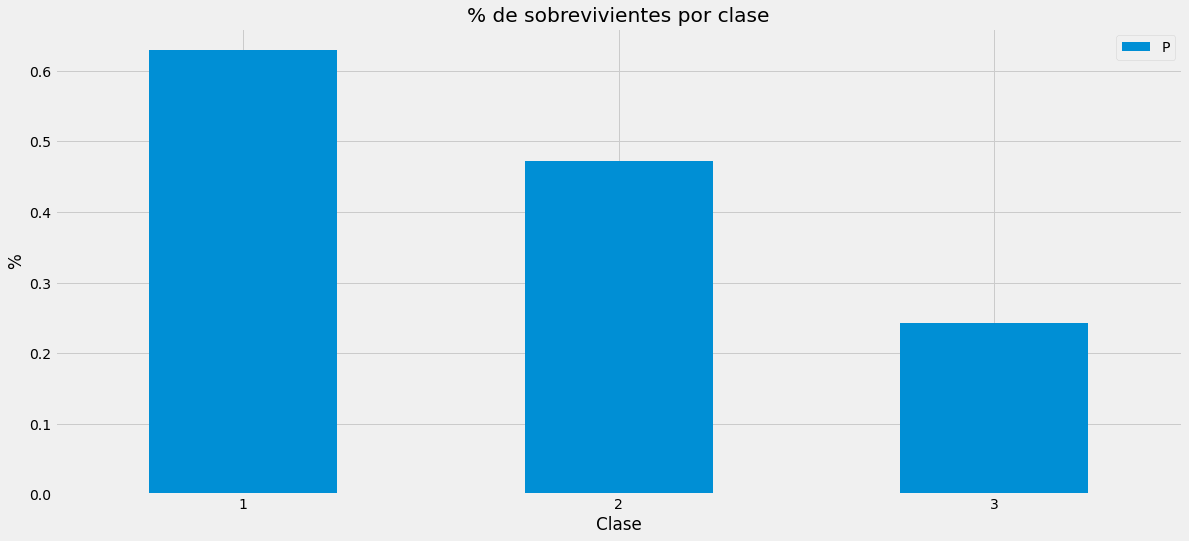

In [303]:
f,ax=plt.subplots(figsize=(18,8))
df[["Survived", "Pclass"]].groupby(by=("Pclass")).mean().plot.bar(ax=ax)
ax.set_title('% de sobrevivientes por clase')
ax.set_ylabel('%')
ax.set_xlabel('Clase')
ax.legend("Pasajeros")
plt.xticks(rotation = 0)

Veo que pese a ser la mayoria de los pasajeros, las personas que viajaban en tercera clase tuvieron una menor tasa de supervivencia mientras que los de primera, que eran solo un 24% de los pasajeros tuvieron una tasa de superviviencia por encima del 60%

## Tasa de supervivencia discriminado por el sexo y la clase

Paso a integrar las variables analizadas hasta ahora

In [304]:
df.groupby(["Survived","Sex","Pclass"])[["Pclass"]].count()

Pclass
Survived Sex    Pclass        
0        female 1            3
                2            6
                3           72
         male   1           77
                2           91
                3          300
1        female 1           91
                2           70
                3           72
         male   1           45
                2           17
                3           47

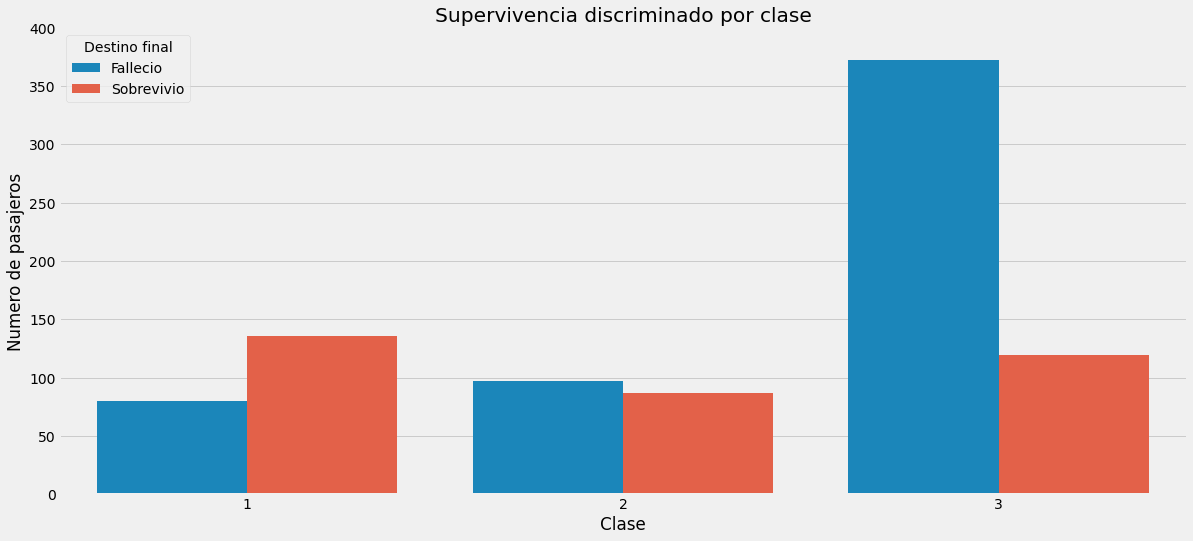

In [305]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(x=df["Pclass"], hue=df["Survived"],ax=ax)
ax.set_title('Supervivencia discriminado por clase')
ax.set_ylabel('Numero de pasajeros')
ax.set_xlabel('Clase')
ax.set_ylim(0,400)
ax.legend(title='Destino final', loc='upper left', labels=['Fallecio', 'Sobrevivio'])
plt.show()

Se puede ver que las personas pertenecientes a la terecera clase tenian una menor tasa de superviviencia que cualquiera de los otros grupos a pesar de ser un 55% del total de los pasajeros. Sumado al analisis discriminado por genero, llevaria a suponer que los individuos con menor tasa de superviviencia serian los hombres de tercera clase.


Al hacer el analisis de lo que fue la superviviencia de los pasajeros puede verse que el sexo de la persona y la clase fueron factores que influyeron, siendo los hombres de tercera clase los de menor probabilidad de sobrevivir, seguido por los hombres de segunda clase, los hombres de primera clase. Paralelamente, el grupo poblacional con mas probabilidad de supervivencia fueron las mujeres de primer, segunda y tercer clase respectivamente.

#  Ultimas variables categoricas del dataset:

### Sitio de Embarque

Investigar si hubo diferencias en las tasa de supervivencia dependiendo del lugar de embarque.

In [306]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Hay dos pasajeros que no tienen registrado el lugar del embarque. Paso a identificar a esos pasajeros e intentar completar esa informacion

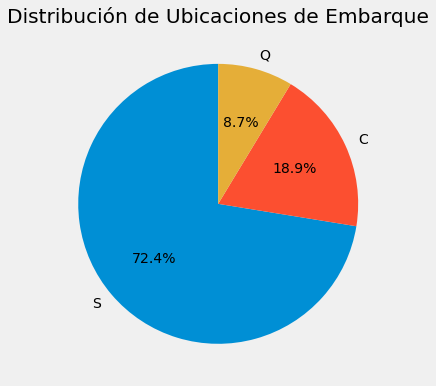

In [307]:
# Obtener el conteo de valores únicos en la columna "Embarked"
embarked_counts = df['Embarked'].value_counts()

# Crear el gráfico de pastel
plt.figure(figsize=(6, 6))
plt.pie(embarked_counts, labels=embarked_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Ubicaciones de Embarque') 
plt.show()  # Mostrar el gráfico de pastel

Como un 72 % de los pasajeros abordo desde la locacion "S"=, completo esos dos valores null que habia en el dataset usando esta locacion.

In [308]:
df.loc[df["Embarked"].isnull(),'Embarked']= "S"

In [309]:
df[["Survived","Ticket","Embarked" ]].groupby(["Survived","Embarked"]).count()

Ticket
Survived Embarked        
0        C             75
         Q             47
         S            427
1        C             93
         Q             30
         S            219

In [310]:
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


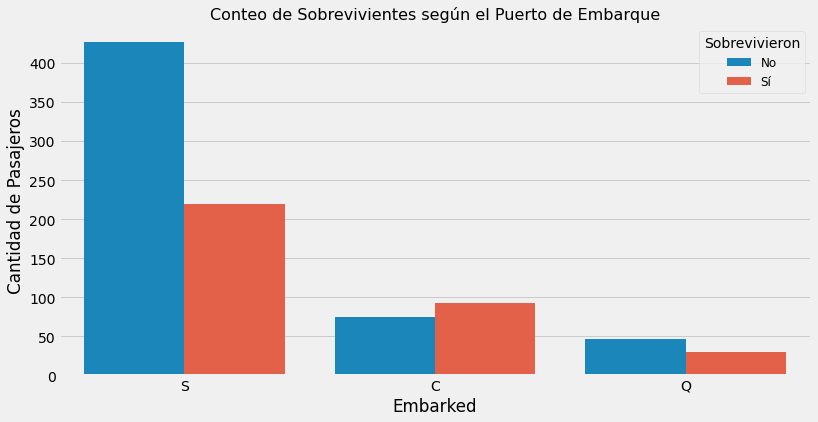

In [311]:
#df[["Survived","Ticket","Embarked" ]].groupby("Embarked").mean()
f,ax=plt.subplots(figsize=(12,6))
sns.countplot(x=df["Embarked"],hue=df['Survived'])
plt.title('Conteo de Sobrevivientes según el Puerto de Embarque', fontsize=16)
plt.ylabel('Cantidad de Pasajeros')
ax.legend(title='Sobrevivieron', labels=['No', 'Sí'], loc='upper right', fontsize=12)
plt.show()

Aquellos pasajeros que embarcaron en la terminal "C" tuvieron una mayor tasa de supervivencia, seguramente porque en esa terminal la mayoria de las personas que embarcaron estaban en primera clase o incluos porque embarcaron mas mujeres.

Text(0.5, 0, 'Lugar de embarque')

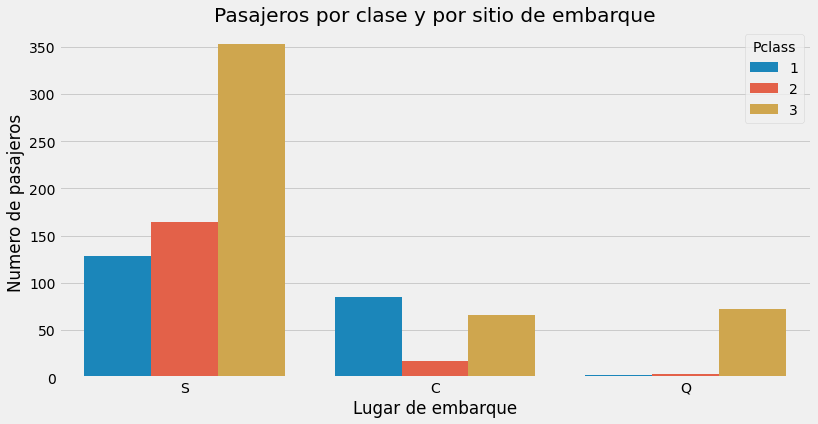

In [312]:
f,ax=plt.subplots(figsize=(12,6))
sns.countplot(x=df["Embarked"],hue=df['Pclass'])
ax.set_title('Pasajeros por clase y por sitio de embarque')
ax.set_ylabel('Numero de pasajeros')
ax.set_xlabel('Lugar de embarque')

Se puede ver que la mayoria de los pasajeros que embarcaron en la locacion "C" eran de primera clase y como vimos anteriormente este era el grupo de personas que tuvo mas chances de sobrevivir. Al mismo tiempo, en el sitio de embraque "S", pese a que una importante cantidad de pasajeros de primera clase, la tasa de suprevivencia de esa locacion e menor ddebido a la gran cantidad de pasajeros de tercera clase que tambien abordaron.

## Pclase y embarque vs superviviencia

<Axes: xlabel='Embarked', ylabel='Survived'>

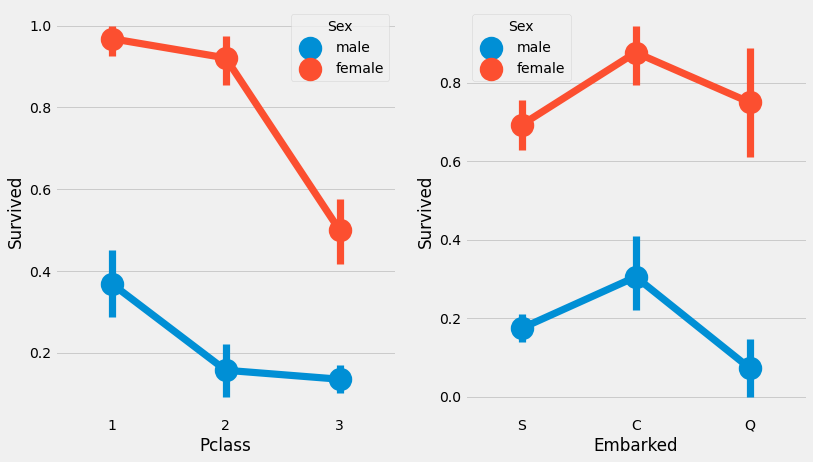

In [313]:
f,ax=plt.subplots(1,2,figsize=(12,7))
sns.pointplot(data=df,x='Pclass', y='Survived', hue="Sex", ax=ax[0])
sns.pointplot(data=df,x='Embarked', y='Survived', hue="Sex", ax=ax[1])

Logro graficar todas las variables categoricas y su relacion con la tasa de supervivencia. Hasta ahora loq ue logre observar fue que:

- Las mujeres tienen una mayora probabilidad que los hombres
- Los pasajeros de primera clase tienen mayor tasa de supervivencia que los de segunda y estos por encima de los de la tercera


Restan por evaluar el impacto de las edades de la personas, cuanto pago por el ticket (si incluso existen diferencias entre la tasa de supervivencia dentro de cada clase dependiendo de cuanto pago por el ticket) y si al viajar solo tuvo mas o menos chances de sobrevivir.

In [314]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Primer aproximacion de un modelo predictivo:

Con la informacion que acabo de ver quiero hacer una primer aproximacion de un modelo predictivo basandonos en el dataset de "Train" con la columna "Survived" del mismo se llevara a cabo un trabajo de clasificacion supervisada. Dentro de los modelos que fueron vistos en la clase puedo utilizar un arbol de decision, k-nearest neighbor o una regresion logistica. Adicionalemnte se buscaran otros modelos que cumplan con la tarea de clasificacion supervisada que no hayan sido vistos en la clase.

Hasta ahora las variables que evalue fueron:

- El sexo
- La clase

Si bien no espero que solo estas dos variables alcancen para construir un modelo predictivo robusto son las analizadas hasta ahora y quiero ver como desempeñan. Lo primero que tengo que hacer es convertir las variables de la columna "Sexo" del dataframe a variables numericas para poder usarlas para entrenar al modelo.

In [315]:
data_binaria=df

In [316]:
data_binaria["Sexo"]=data_binaria["Sex"].map({'male': 0, 'female': 1})

In [317]:
entry_modelo=data_binaria.drop(["PassengerId", "Name", "Sex","Age", "SibSp","Parch","Ticket","Fare","Cabin","Embarked"], axis=1)

In [318]:
entry_modelo  #informacion quese le va a limentar al modelo para entrenarlo

,Survived,Pclass,Sexo
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0
...,...,...,...
886,0,2,0
887,1,1,1
888,0,3,1
889,1,1,0


# Variables continuas

Se lleva a cabo el proceso de data wrangling de las variables continuas presentes en el dataset con el objetivo de limpiar el dataset que voy a ausar para entrenar mi modelo predictiv. De esta manera se busca reducir lo maximo posibe los errores, tener un mejor entendimeinto de la informacion presente dentro del dataframe y maximizar la capacidad predictiva del modelo a utilizar.

#### Data Wrangling:

Se hace una limpieza de los datos aun no analizados. El objetivos es buscar valores nulos, errores en en ingreso de los datos, convertir variables categoricas en numericas para ser incluidas como variable que alimente al modelo.

## Efecto edad en la probabiidad de sobrevivir de la persona

Paso a analizar como la edad afecto la probabilidad de sobrevivir del pasajero. Se ve que gran parte de las personas a bordo estaban entre los 20 y 30 años y que en su gran mayoria no sobrevivieron. Vale la pena tener en cuenta esta variable al momento del diseño del modelo predictivo.

In [319]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [320]:
df.shape

(891, 13)

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Sexo         891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [322]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Sexo             0
dtype: int64

Puedo ver que una de las columnas que mas datos nulos contiene es el de la edad y el numero de cabina. Arranco por la columna de la edad que puede ser una variable mas importante en la determinacion de la supervivencia de un pasajero.

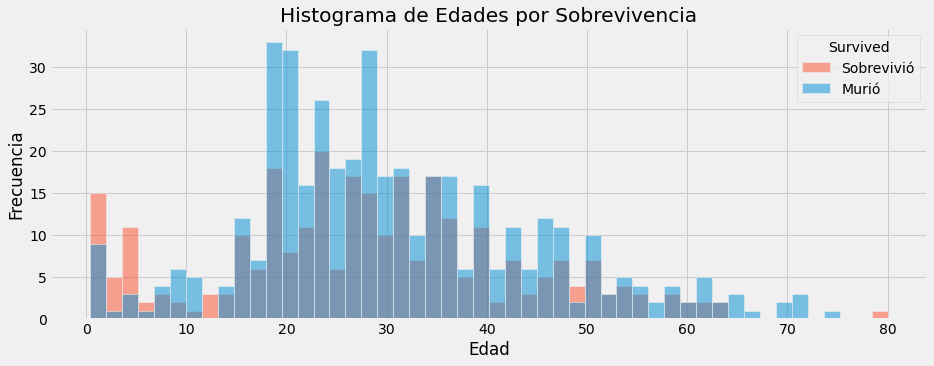

In [323]:
plt.figure(figsize=(14, 5))
ax = sns.histplot(data=df,x="Age",bins=50, hue="Survived")
ax.set(title='Histograma de Edades por Sobrevivencia', xlabel='Edad', ylabel='Frecuencia')
ax.legend(title='Survived', labels=['Sobrevivió', 'Murió'])

Como puede verse en el grafico gran parte de las personas a bordo tenian entre 20 y 30 años. Este grupo etario parece tener la menor tasa de supervivencia. Esto hace suponer que los niños fueron priorizados a la hora de evacuar el barco y seran los que mayor probabilidad de sobrevivir. Sin embargo en mi dataset 177 filas no contienen la informacion de edad. Eliminar esas filas no es una opcion ya que perderia gran parte de la informacion que tengo disponible para el entrenamiento de mi modelo. Tengo que buscar una variable que se relacione con la edad a partir de la cual yo pueda estimar la edad de las personas que o contienen esa informacion.

La columna de "Name" contiene el nombre de la persona antecedido de un titulo de "seniority" (Mr, Miss). Lo que busco es evitar usar una la edad promedio del dataset para completar estos valores nulos ya que no corresponderia e incluso afectaria la capacidad predictiva de mi modelo si se le aplico esa edad de forma indiferenciada a niños, mujeres hombres y ancianos. Si logro identificar la edad promedio de cada una de estas categorias podria completar las filas que les falta este dato. Lo primero que tengo que hacer es extraer esta parte del string usando un split.

In [324]:
df["Titulo"]=df['Name'].str.split(',').str[1].str.strip()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexo,Titulo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr. Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs. John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss. Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs. Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr. William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Rev. Juozas
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss. Margaret Edith
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1,"Miss. Catherine Helen ""Carrie"""
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,Mr. Karl Howell


In [325]:
df["Titulo"]=df["Titulo"].str.split('.').str[0].str.strip()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexo,Titulo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,Mr


In [326]:
df["Titulo"]=df["Titulo"].str.split(' ').str[0].str.strip()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexo,Titulo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,Mr


In [327]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexo,Titulo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr


In [328]:
df["Titulo"].value_counts()

Titulo
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
the           1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [329]:
missing_age=df[["Titulo", "Age"]]

In [330]:
listado=missing_age[missing_age['Age'].isnull()]

In [331]:
listado["Titulo"].value_counts()

Titulo
Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: count, dtype: int64

En primera instancia gran parte de las filas donde el dato de la edad falta seria de hombres "Mr.", seguidos de mujeres solteras "Miss." (seguramente muy jovenes), seguido por mujeres casadas "Mrs.". En el caso de Master podria ser un noble o un niño, vale la pena ver la edad promedio del resto de los registros con ese titulo. El resto de las categorias:

Dr. ---- presupones ser un masculino de mayoria de edad, puedo usar la edad promedio de las edades de esta categoria.


In [332]:
df.groupby(["Titulo"])["Age"].mean()

Titulo
Capt        70.000000
Col         58.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       4.574167
Miss        21.773973
Mlle        24.000000
Mme         24.000000
Mr          32.368090
Mrs         35.898148
Ms          28.000000
Rev         43.166667
Sir         49.000000
the         33.000000
Name: Age, dtype: float64

Aca tenemos la edad promedio de cada una de las categorias dentro de la columna "Titulo". Esta informacion la podria usar para completar los valores nulos basandome en los titulos de cada persona abordo. Sin embargo primero parece que hay que limpiarla. Hay titulos que no tienen sentido y parecerian errores en el ingreso de informacion.

In [333]:
df["Titulo"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the', 'Jonkheer'],
      dtype=object)

In [334]:
df.loc[df["Titulo"]=="Jonkheer"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sexo,Titulo
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S,0,Jonkheer


In [335]:
df['Titulo'].replace(['Don','Mme', 'Ms', 'Mlle','the Countess','Jonkheer'],
                       ["Mr", "Miss", "Miss","Miss","Mrs", "Mr" ], inplace=True)

Haciendo esto busco simplificar la cantidad de titulos en el dataset para extraer mejor las edades promedio que necesito para completar las celdas vacias.

In [336]:
df["Titulo"].value_counts()

Titulo
Mr        519
Miss      186
Mrs       125
Master     40
Dr          7
Rev         6
Major       2
Col         2
Lady        1
Sir         1
Capt        1
the         1
Name: count, dtype: int64

In [337]:
df.groupby('Titulo')['Age'].mean()

Titulo
Capt      70.000000
Col       58.000000
Dr        42.000000
Lady      48.000000
Major     48.500000
Master     4.574167
Miss      21.860000
Mr        32.401250
Mrs       35.898148
Rev       43.166667
Sir       49.000000
the       33.000000
Name: Age, dtype: float64

Paso a completar los missing values de las categorias que liste anteriormente

In [338]:
df.loc[(df["Age"].isnull()) & (df["Titulo"]=='Mr'),'Age']=33
df.loc[(df["Age"].isnull()) & (df["Titulo"]=='Mrs'),'Age']=36
df.loc[(df["Age"].isnull()) & (df["Titulo"]=='Master'),'Age']=5
df.loc[(df["Age"].isnull()) & (df["Titulo"]=='Miss'),'Age']=22
df.loc[(df["Age"].isnull()) & (df["Titulo"]=='Dr'),'Age']=42

##### Paso a verificar qeu los cambios se hicieron dentro del dataframe

In [339]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Sexo             0
Titulo           0
dtype: int64

## Simplifico los titulos

Simplifico la cantidad de titulos para graficar la tasa de superviviencia de cada grupo especifico

In [340]:
df.groupby('Titulo')['Age'].mean()

Titulo
Capt      70.000000
Col       58.000000
Dr        42.000000
Lady      48.000000
Major     48.500000
Master     4.616750
Miss      21.887097
Mr        32.538536
Mrs       35.912000
Rev       43.166667
Sir       49.000000
the       33.000000
Name: Age, dtype: float64

In [341]:
titulos_a_reemplazar = ['Capt', 'Col', 'Dr', "Major","Rev", "Sir", "the" ]
df['Titulo'] = df['Titulo'].replace(titulos_a_reemplazar, 'Mr')

titulos_a_reemplazar_2 = ["Lady"]
df['Titulo'] = df['Titulo'].replace(titulos_a_reemplazar_2, 'Mrs')

In [342]:
df.groupby('Titulo')['Age'].mean()

Titulo
Master     4.616750
Miss      21.887097
Mr        33.034323
Mrs       36.007937
Name: Age, dtype: float64

## Grafico como fue la tasa de supervivencia dependiendo del grupo etario
Busco visualizar de forma mas simple como fue la tasa de mortalidad dependiendo del rango etario al que pertenece cada pasajero

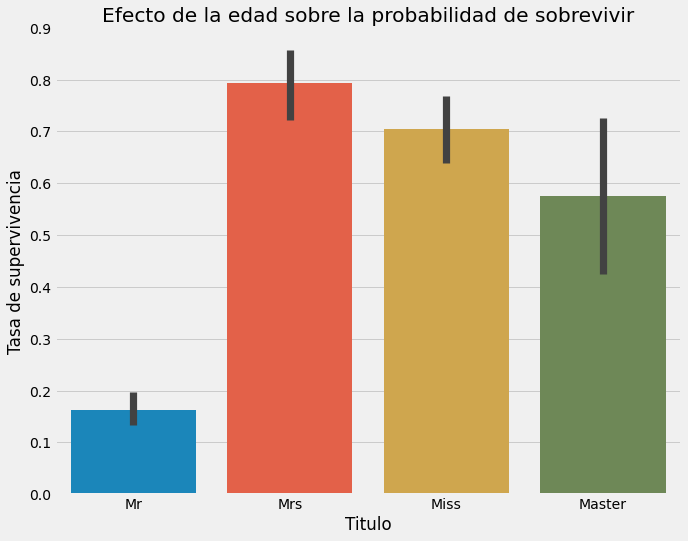

In [343]:
f,ax=plt.subplots(figsize=(10,8))
sns.barplot(data=df,x='Titulo', y='Survived')
plt.xlabel('Titulo')  # Etiqueta del eje x
plt.ylabel('Tasa de supervivencia')  # Etiqueta del eje y
plt.title('Efecto de la edad sobre la probabilidad de sobrevivir')
plt.show()

In [344]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sexo', 'Titulo'],
      dtype='object')

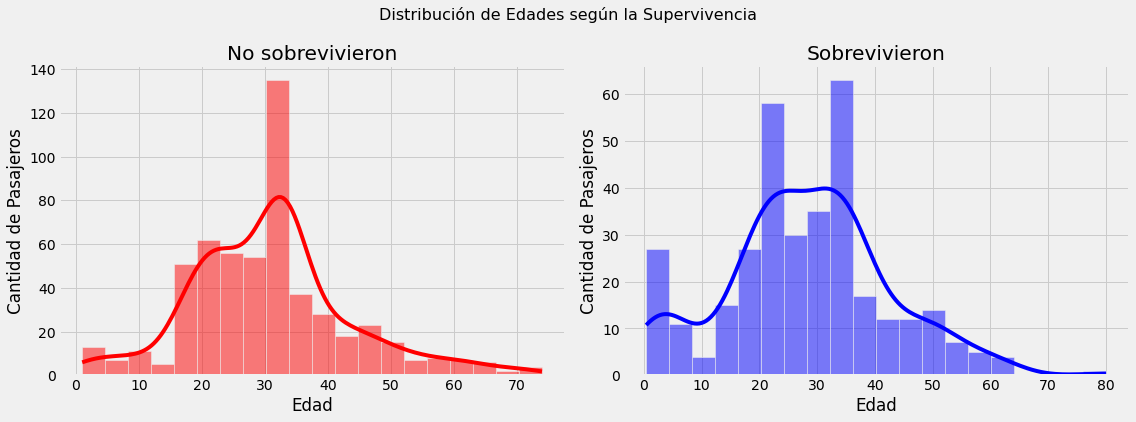

In [345]:
plt.figure(figsize=(16, 6))  # Tamaño total del área de los dos gráficos (ancho, alto)

# Histograma para la distribución de edades de los pasajeros que no sobrevivieron (Survived=0)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, subfigura 1
sns.histplot(data=df[df['Survived'] == 0], x='Age', bins=20, kde=True, color='red')
plt.xlabel('Edad')  # Etiqueta del eje x
plt.ylabel('Cantidad de Pasajeros')  # Etiqueta del eje y
plt.title('No sobrevivieron')  # Título de la subfigura

# Histograma para la distribución de edades de los pasajeros que sobrevivieron (Survived=1)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, subfigura 2
sns.histplot(data=df[df['Survived'] == 1], x='Age', bins=20, kde=True, color='blue')
plt.xlabel('Edad')  # Etiqueta del eje x
plt.ylabel('Cantidad de Pasajeros')  # Etiqueta del eje y
plt.title('Sobrevivieron')  # Título de la subfigura

plt.suptitle('Distribución de Edades según la Supervivencia', fontsize=16)  # Título para todo el conjunto de gráficos
plt.tight_layout()  # Ajustar los márgenes para evitar superposiciones
plt.show()  # Mostrar el conjunto de gráficos

Puede verse en el grafico que los niños fueron priorizados para evacuar el barco debido a una mayor cantidad de sobrevivientes dentro del rango etario de entre 0 y 10 años. 

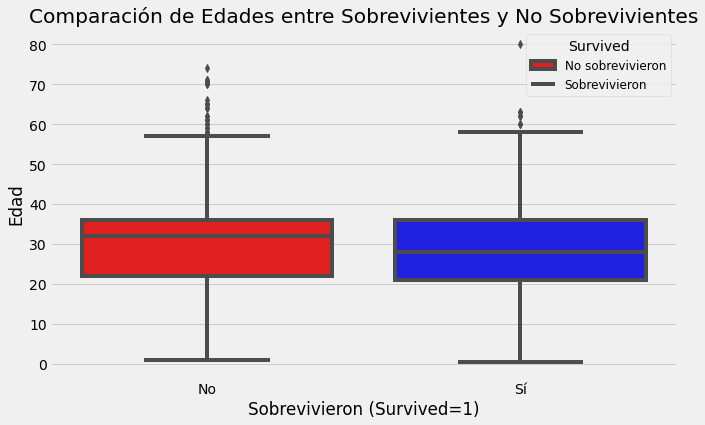

In [346]:
plt.figure(figsize=(10, 6))  # Tamaño del gráfico (ancho, alto)

# Diagrama de cajas para comparar las distribuciones de edades
sns.boxplot(data=df, x='Survived', y='Age', palette={0: 'red', 1: 'blue'})

plt.xlabel('Sobrevivieron (Survived=1)')  # Etiqueta del eje x
plt.ylabel('Edad')  # Etiqueta del eje y
plt.title('Comparación de Edades entre Sobrevivientes y No Sobrevivientes')  # Título del gráfico
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])  # Etiquetas personalizadas para el eje x
plt.legend(title='Survived', labels=['No sobrevivieron', 'Sobrevivieron'], loc='best', fontsize=12)
plt.show()  # Mostrar el gráfico

Puede verse que la edad de las personas que sobrevivieron fue mucho menor, en promedio, a lo que no sobrevivieron aunque se ven outliers dentro de ambos grupos de personas de mas de 60 años.

In [347]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Sexo             0
Titulo           0
dtype: int64

En el caso de la variable "Cabin" gran parte de los datos faltan por lo cual no va a poder ser usada como una variable que forme parte de mi modelo predictivo

# Valor del pasaje

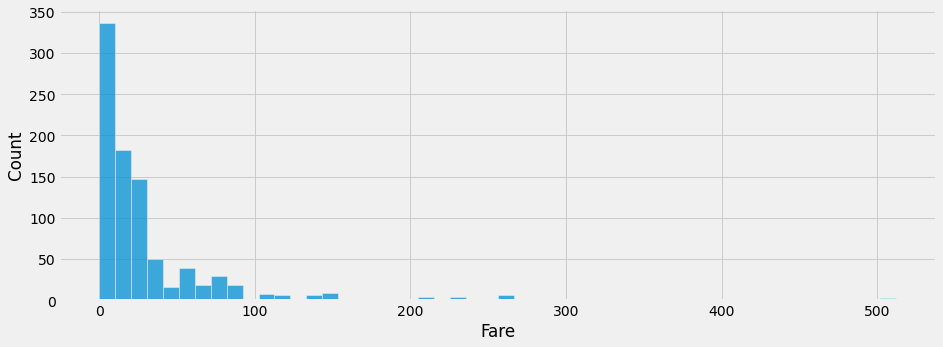

In [348]:
plt.figure(figsize=(14, 5))
sns.histplot(data=df,x="Fare",bins=50)
plt.show()

Se puede ver que gran parte de los tickets vendidos corresponden a pasajes baratos, seguramente de tercera clase y tiene una distribucion asimentrica. Para ser incluida en el modelo deberia buscar normalizar la informacion con el objetivo de facilitar el uso de esta variable. 

In [349]:
import scipy
scipy.stats.describe(df["Fare"])

DescribeResult(nobs=891, minmax=(0.0, 512.3292), mean=32.204207968574636, variance=2469.436845743116, skewness=4.7792532923723545, kurtosis=33.20428925264474)

Text(0.5, 1.0, 'No sobrevivieron')

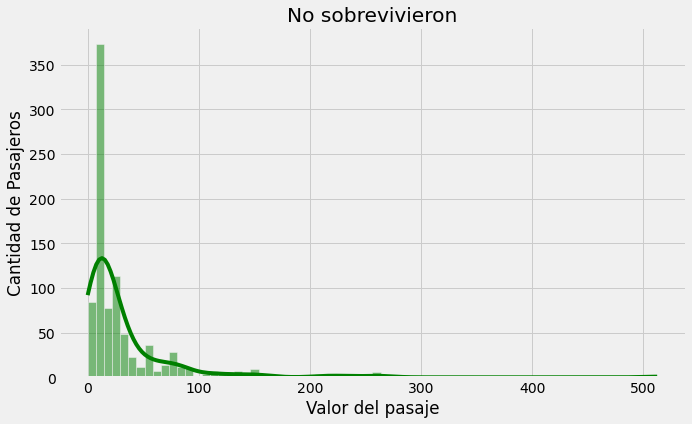

In [350]:
plt.figure(figsize=(10, 6))
plt.subplot()  # 1 fila, 2 columnas, subfigura 1
sns.histplot(data=df, x='Fare', bins=70, kde=True, color='green')
plt.xlabel('Valor del pasaje')  # Etiqueta del eje x
plt.ylabel('Cantidad de Pasajeros')  # Etiqueta del eje y
plt.title('No sobrevivieron')  # Título de la subfigura

Separo la distribucion del valor del pasaje dependiendo de la clase que cada pasajero abordo

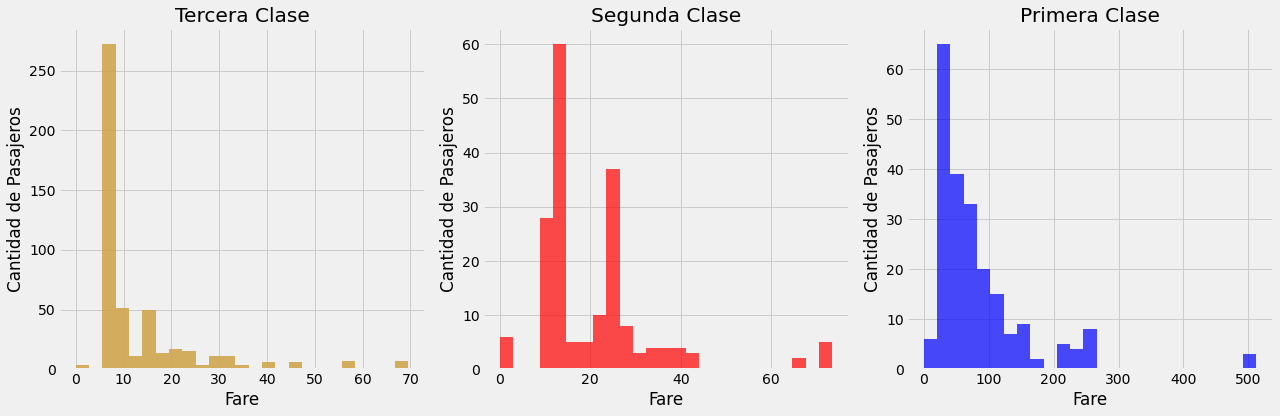

In [351]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))



# Gráfico 3: Distribución de "Fare" en tercera clase (Pclass=3)
axes[0].hist(df[df['Pclass'] == 3]['Fare'], bins=25, color='#CFA64E', alpha=0.9)
axes[0].set_title('Tercera Clase')
axes[0].set_xlabel('Fare')
axes[0].set_ylabel('Cantidad de Pasajeros')

# Gráfico 2: Distribución de "Fare" en segunda clase (Pclass=2)
axes[1].hist(df[df['Pclass'] == 2]['Fare'], bins=25, color='red', alpha=0.7)
axes[1].set_title('Segunda Clase')
axes[1].set_xlabel('Fare')
axes[1].set_ylabel('Cantidad de Pasajeros')

# Gráfico 1: Distribución de "Fare" en primera clase (Pclass=1)
axes[2].hist(df[df['Pclass'] == 1]['Fare'], bins=25, color='blue', alpha=0.7)
axes[2].set_title('Primera Clase')
axes[2].set_xlabel('Fare')
axes[2].set_ylabel('Cantidad de Pasajeros')


plt.tight_layout()  # Ajustar los márgenes para evitar superposiciones
plt.show()  # Mostrar los tres gráficos

A partir de la visualizacion y por la informacion que revela el analisis de stats, tengo una marcada asimetria positiva, donde la mayoria de los datos se concentran en los valores mas bajos. Estoes debido a que gran parte de los pasajeros a bordo correspondian a pasajeros de tercera clase, cuyos tpasajes eran mas baratos. Debdo a esto no uedo asumir gran parte de los supuestos que le corresponderian a una variable con distribucion normal. Para la facilitar mi analisis debo llevar a cabo transfomraciones con el objetivo de lograr disminuir la asimetria y lograr una distribucion nomal de los datos.

In [352]:
df['Fare_log_norm'] = np.log1p(df['Fare'])

Text(0.5, 1.0, 'No sobrevivieron')

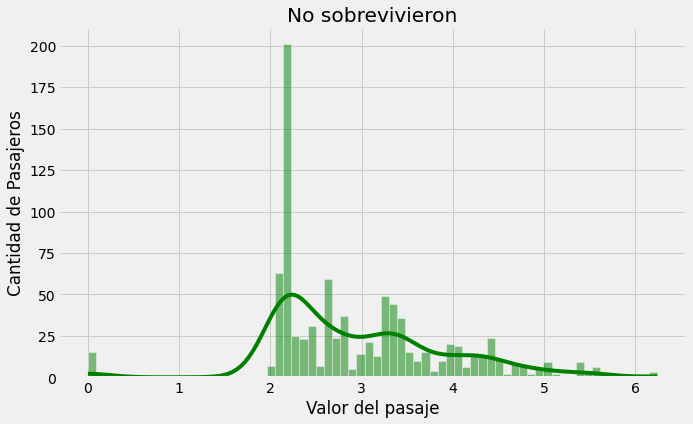

In [353]:
plt.figure(figsize=(10, 6))
plt.subplot()  # 1 fila, 2 columnas, subfigura 1
sns.histplot(data=df, x='Fare_log_norm', bins=70, kde=True, color='green')
plt.xlabel('Valor del pasaje')  # Etiqueta del eje x
plt.ylabel('Cantidad de Pasajeros')  # Etiqueta del eje y
plt.title('No sobrevivieron')  # Título de la subfigura

In [354]:
import scipy
scipy.stats.describe(df["Fare_log_norm"])

DescribeResult(nobs=891, minmax=(0.0, 6.240917354759096), mean=2.9622457416890815, variance=0.9390545498271524, skewness=0.39426283638993376, kurtosis=0.9639464598718401)

A partir de una transformacion logaritmica logramos disminuir la asimentria del set de datos lo que nos permite tratar los datos con los supuestos de una distribucion normal.

In [355]:
df.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sexo', 'Titulo',
       'Fare_log_norm'],
      dtype='object')

In [356]:
df.drop(columns=["Cabin", "Ticket", "Name"], inplace = True)

In [357]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sexo,Titulo,Fare_log_norm
0,1,0,3,male,22.0,1,0,7.2500,S,0,Mr,2.110213
1,2,1,1,female,38.0,1,0,71.2833,C,1,Mrs,4.280593
2,3,1,3,female,26.0,0,0,7.9250,S,1,Miss,2.188856
3,4,1,1,female,35.0,1,0,53.1000,S,1,Mrs,3.990834
4,5,0,3,male,35.0,0,0,8.0500,S,0,Mr,2.202765


# Efecto de la familia sobre la tasa de supervivencia

Las ultimas variables que falta analizar son "SibSp" (numero de hermanos que cada pasajero tena a bordo) y "Parch" (numero de padres que cada pasajero tenia a bordo). Quiero ver si la cantidad de familiares que un pasajero tenia a bordo afecta la tasa de superviviencia.

Text(0.5, 1.0, 'Tasa de supervivencia dependiendo del numero de hermanos a bordo')

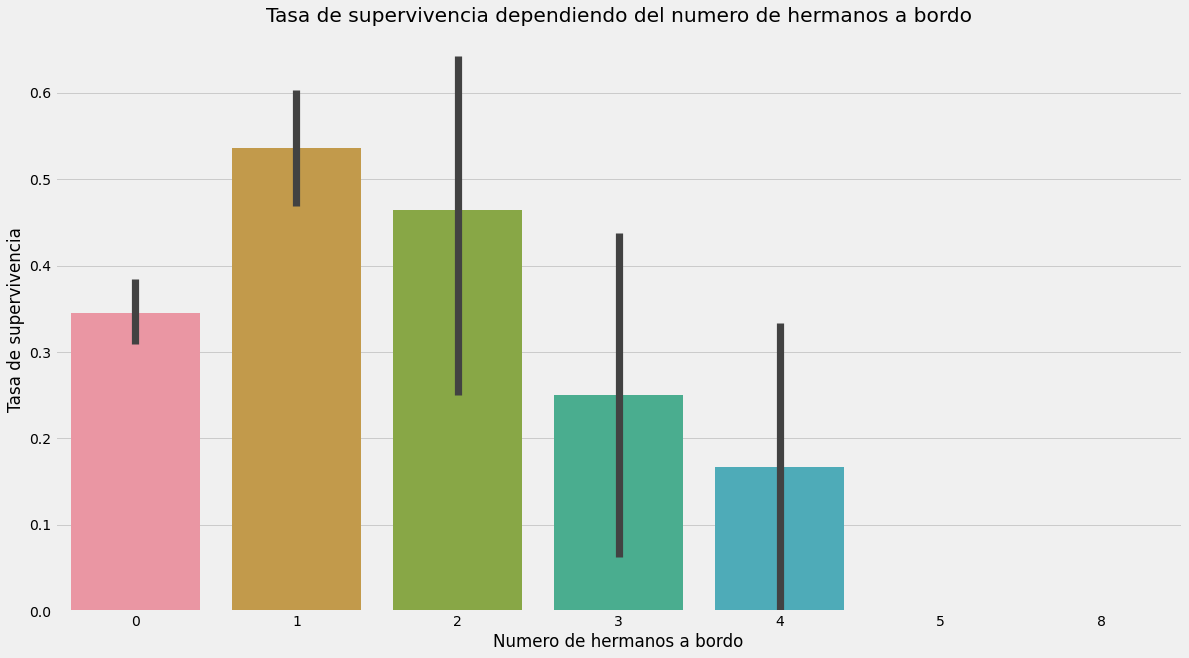

In [358]:
f,ax=plt.subplots(figsize=(18,10))
sns.barplot(data=df,x='SibSp', y='Survived')
plt.xlabel('Numero de hermanos a bordo')  # Etiqueta del eje x
plt.ylabel('Tasa de supervivencia')  # Etiqueta del eje y
plt.title('Tasa de supervivencia dependiendo del numero de hermanos a bordo')  # Título de la subfigura

Puede verse que aquellas personas que viajaban solas o tenian muchos hermanos a bordo tenian las menores probabilidades de sobrevivir. Esto puede ser debido a que en el caso de personas solas, muy comunmente eran hombres solos dentro de un rango etario de 20 a 40 años. Mientras que las personas que tenian muchos hermanos seguramente corresponidan a pasajeros de terecera clase.

In [359]:
sin_hermanos=df.loc[df['SibSp'] == 0]

Text(0.5, 1.0, 'Numero de pasajeros sin hermanos a bordo')

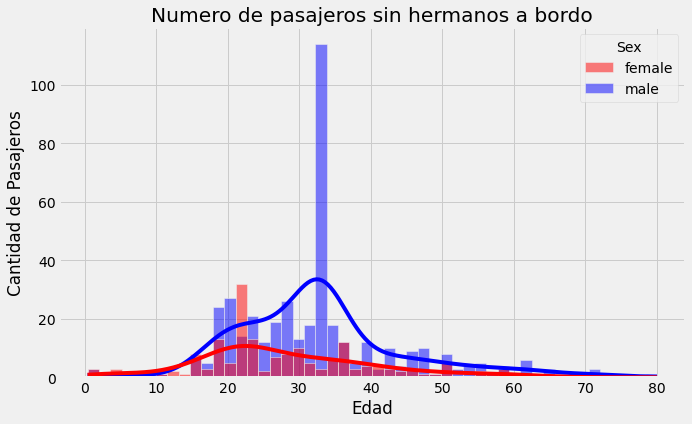

In [360]:
plt.figure(figsize=(10, 6))
plt.subplot()  # 1 fila, 2 columnas, subfigura 1
sns.histplot(data=sin_hermanos, x='Age', bins=50, kde=True, hue="Sex", palette={'female': 'red', 'male': 'blue'})
plt.xlabel('Edad')  # Etiqueta del eje x
plt.ylabel('Cantidad de Pasajeros')  # Etiqueta del eje y
plt.title('Numero de pasajeros sin hermanos a bordo')  # Título de la subfigura

Se observa que las mujeres que vijaban sin familiares tenian mayor probabilidad de sobrevivir que lo hombres

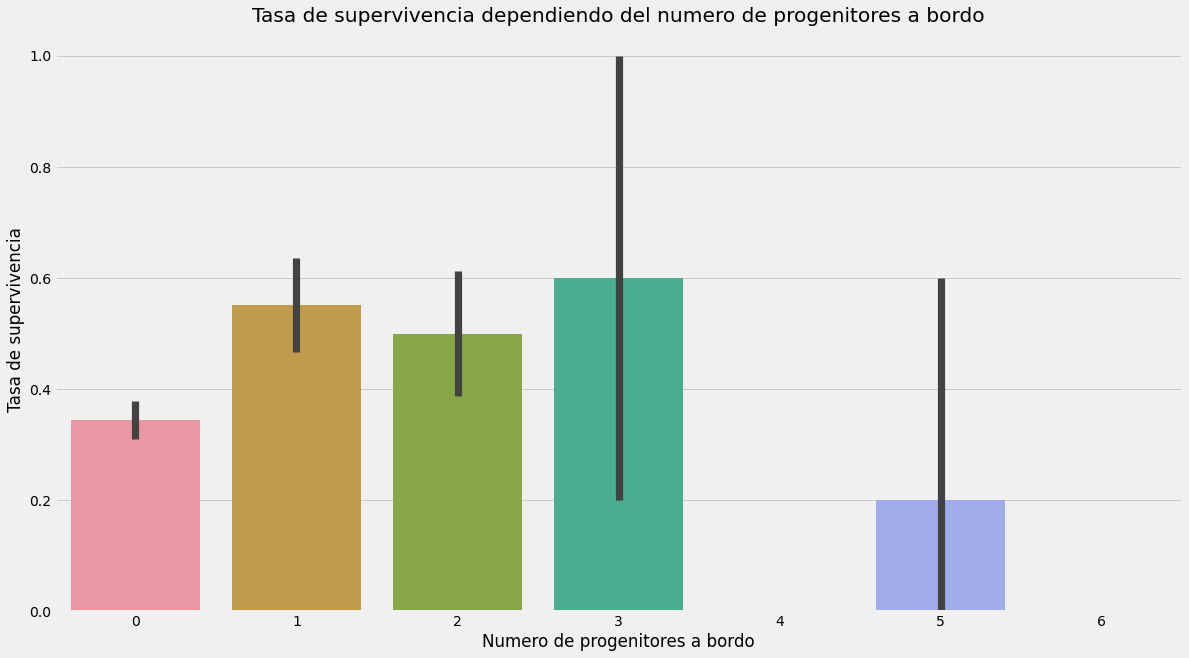

In [361]:
f,ax=plt.subplots(figsize=(18,10))
sns.barplot(data=df,x='Parch', y='Survived')
plt.xlabel('Numero de progenitores a bordo')  # Etiqueta del eje x
plt.ylabel('Tasa de supervivencia')  # Etiqueta del eje y
plt.title('Tasa de supervivencia dependiendo del numero de progenitores a bordo')
plt.show()

ALgo similar pasa con la cantidad de "padres" que acompañabana cada pasajero. Para aquellas personas que viajaban solas, la tasa de mortalidad era mayor al igual que los que viajaban con mas de 5 adultos (tios, tias, tutores, etc.)

Text(0.5, 1.0, 'Numero de pasajeros sin padres a bordo')

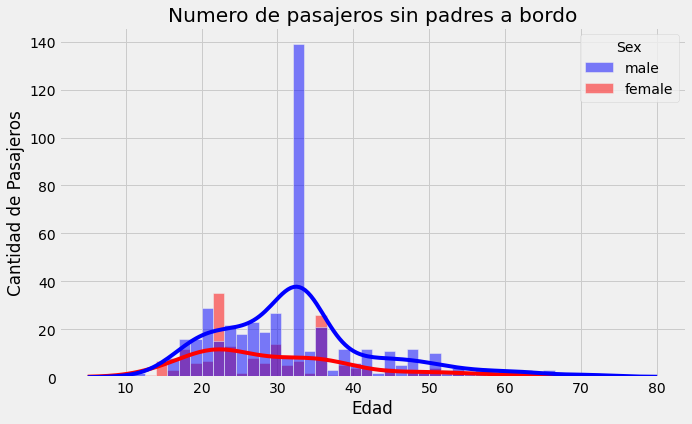

In [362]:
sin_padres=df.loc[df['Parch'] == 0]
plt.figure(figsize=(10, 6))
plt.subplot()  # 1 fila, 2 columnas, subfigura 1
sns.histplot(data=sin_padres, x='Age', bins=50, kde=True, hue="Sex", palette={'female': 'red', 'male': 'blue'})
plt.xlabel('Edad')  # Etiqueta del eje x
plt.ylabel('Cantidad de Pasajeros')  # Etiqueta del eje y
plt.title('Numero de pasajeros sin padres a bordo')  # Título de la subfigura

Para ver el efecto combinado de ambos factores creo una nueva columna para determinar la cantidad total de familiares que cada pasajero tenia a bordo y correlacionar eso con la clase en la que viajaba y la tasa de supervivencia del mismo 

In [363]:
df["Total_Familiares"]=df["SibSp"]+df["Parch"]

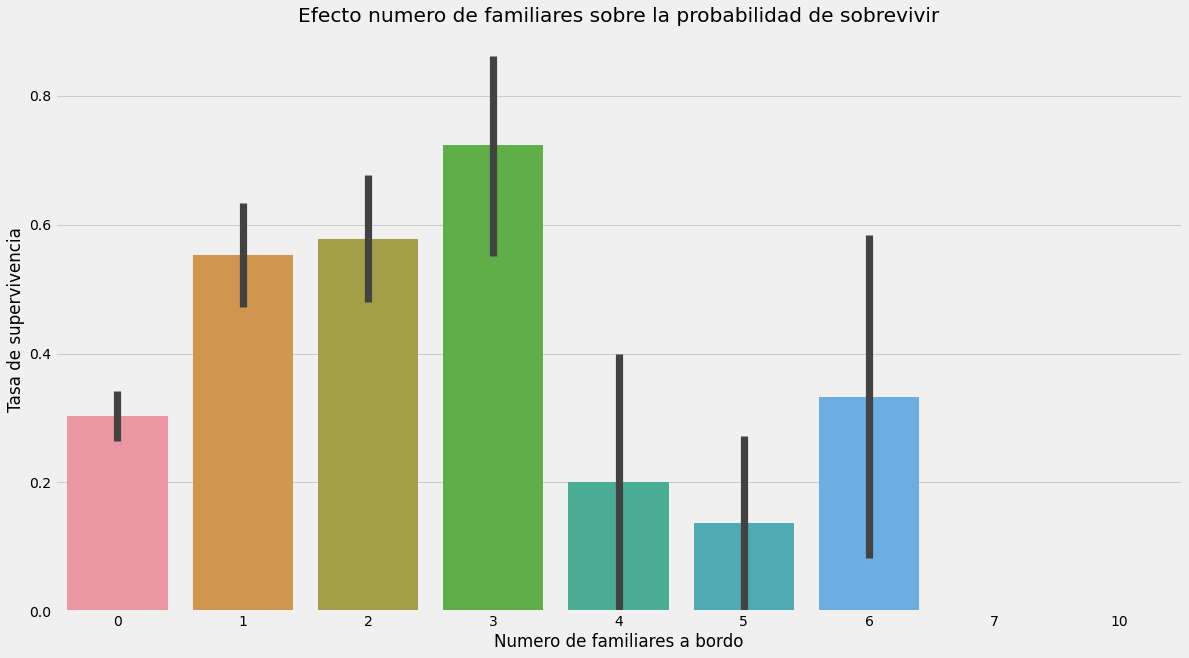

In [364]:
f,ax=plt.subplots(figsize=(18,10))
sns.barplot(data=df,x='Total_Familiares', y='Survived')
plt.xlabel('Numero de familiares a bordo')  # Etiqueta del eje x
plt.ylabel('Tasa de supervivencia')  # Etiqueta del eje y
plt.title('Efecto numero de familiares sobre la probabilidad de sobrevivir')
plt.show()

In [365]:
df.loc[df["Total_Familiares"]>=4].groupby(by="Pclass").count()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,Sexo,Titulo,Fare_log_norm,Total_Familiares
Pclass,,,,,,,,,,,,
1,6,6,6,6,6,6,6,6,6,6,6,6
2,2,2,2,2,2,2,2,2,2,2,2,2
3,54,54,54,54,54,54,54,54,54,54,54,54


A partir de este grafico puede verse que pasajeros que viajaban solos tenian menor chances de sobrevivir que aquellos que viajaban acompañdos. Al mimso timepo familias muy numerosas, correspondientes a pasajeros de tercera clase, tambien tenian menores chances de sobrevivir.

# Resumen de las observaciones registradas hasta ahora

-Las mujeres tienen mayor probabilidad de sobrevivir
-Los niños menores a 10 años tienen mayor probabilidad de sobrevivir
-Los pasajeros de primera clase tienen mayor probabilidad de sobrevivir
-Los pasajeros que viajan solos o con una familia de mas de 4 miembros tienen menor probabilidad de sobrevivir
-Los pasajeros del sitio de embarque "C" tuvieron la mayor probabilidad de sobrevivir mientras que lo de la "S" la menor



In [366]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Sexo', 'Titulo', 'Fare_log_norm',
       'Total_Familiares'],
      dtype='object')

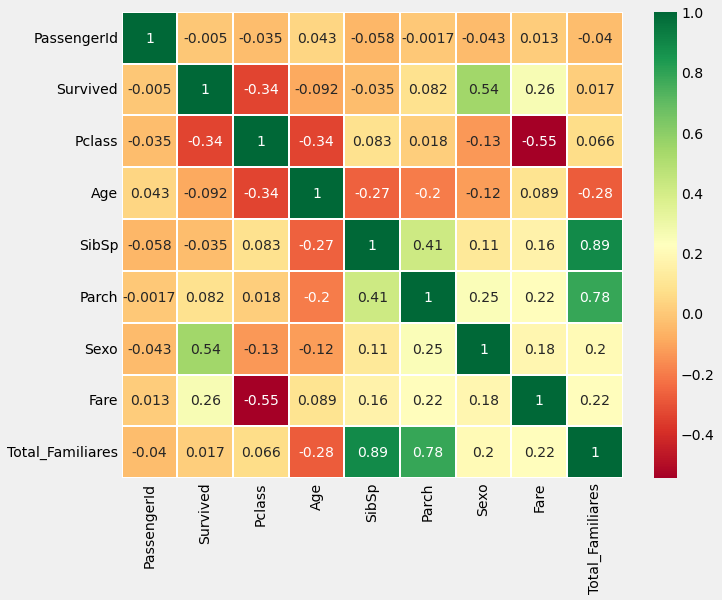

In [367]:
columnas_correlacion = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch',
                        'Sexo', 'Fare', 'Total_Familiares']

# Calcular la matriz de correlación
matriz_correlacion = df[columnas_correlacion].corr()

sns.heatmap(matriz_correlacion,annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

El mapa de correlacion me indica que variables contienen informacion similar entre ellas. El objetivo al entrenar un modelo es que contenga la menor cantidad de variables posible manteniendo la mayor capacidad predictiva. La posibilidad de eliminar/ que una variable sea redundante ya que contiene informacion muy similar se da si hay un alto indice de correlacion entre ambas ej 0,95 o superiror. En mi matriz en particular no se observa tal sitacion por lo cual debo trabajar con cada una de estas variables.

In [368]:
df.drop(["SibSp","Parch", "PassengerId"],axis=1,inplace = True)

In [369]:
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Sexo,Titulo,Fare_log_norm,Total_Familiares
0,0,3,male,22.0,7.2500,S,0,Mr,2.110213,1
1,1,1,female,38.0,71.2833,C,1,Mrs,4.280593,1
2,1,3,female,26.0,7.9250,S,1,Miss,2.188856,0
3,1,1,female,35.0,53.1000,S,1,Mrs,3.990834,1
4,0,3,male,35.0,8.0500,S,0,Mr,2.202765,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,0,Mr,2.639057,0
887,1,1,female,19.0,30.0000,S,1,Miss,3.433987,0
888,0,3,female,22.0,23.4500,S,1,Miss,3.196630,3
889,1,1,male,26.0,30.0000,C,0,Mr,3.433987,0


# Transformacion de variables continuas en categoricas

Con el objetico de simplificar lo dato que el modelo predictivo debe procesar busco convertir variables continuas, como la edad, el vlore del pasaje y el total de familiares en variables categoricas. 

In [370]:
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Sexo,Titulo,Fare_log_norm,Total_Familiares
0,0,3,male,22.0,7.2500,S,0,Mr,2.110213,1
1,1,1,female,38.0,71.2833,C,1,Mrs,4.280593,1
2,1,3,female,26.0,7.9250,S,1,Miss,2.188856,0
3,1,1,female,35.0,53.1000,S,1,Mrs,3.990834,1
4,0,3,male,35.0,8.0500,S,0,Mr,2.202765,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,0,Mr,2.639057,0
887,1,1,female,19.0,30.0000,S,1,Miss,3.433987,0
888,0,3,female,22.0,23.4500,S,1,Miss,3.196630,3
889,1,1,male,26.0,30.0000,C,0,Mr,3.433987,0


In [371]:
df['Age'] = df['Age'].astype(int)

In [372]:
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Sexo,Titulo,Fare_log_norm,Total_Familiares
0,0,3,male,22,7.2500,S,0,Mr,2.110213,1
1,1,1,female,38,71.2833,C,1,Mrs,4.280593,1
2,1,3,female,26,7.9250,S,1,Miss,2.188856,0
3,1,1,female,35,53.1000,S,1,Mrs,3.990834,1
4,0,3,male,35,8.0500,S,0,Mr,2.202765,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,13.0000,S,0,Mr,2.639057,0
887,1,1,female,19,30.0000,S,1,Miss,3.433987,0
888,0,3,female,22,23.4500,S,1,Miss,3.196630,3
889,1,1,male,26,30.0000,C,0,Mr,3.433987,0


In [373]:
pd.cut(df['Age'], bins=5)

0      (16.0, 32.0]
1      (32.0, 48.0]
2      (16.0, 32.0]
3      (32.0, 48.0]
4      (32.0, 48.0]
           ...     
886    (16.0, 32.0]
887    (16.0, 32.0]
888    (16.0, 32.0]
889    (16.0, 32.0]
890    (16.0, 32.0]
Name: Age, Length: 891, dtype: category
Categories (5, interval[float64, right]): [(-0.08, 16.0] < (16.0, 32.0] < (32.0, 48.0] < (48.0, 64.0] < (64.0, 80.0]]

In [374]:
categorias= [0,1,2,3,4]
df["rango_etario"]=pd.cut(df['Age'], bins=5, labels=categorias, right=False)
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Sexo,Titulo,Fare_log_norm,Total_Familiares,rango_etario
0,0,3,male,22,7.2500,S,0,Mr,2.110213,1,1
1,1,1,female,38,71.2833,C,1,Mrs,4.280593,1,2
2,1,3,female,26,7.9250,S,1,Miss,2.188856,0,1
3,1,1,female,35,53.1000,S,1,Mrs,3.990834,1,2
4,0,3,male,35,8.0500,S,0,Mr,2.202765,0,2
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,13.0000,S,0,Mr,2.639057,0,1
887,1,1,female,19,30.0000,S,1,Miss,3.433987,0,1
888,0,3,female,22,23.4500,S,1,Miss,3.196630,3,1
889,1,1,male,26,30.0000,C,0,Mr,3.433987,0,1


In [375]:
pd.qcut(df['Fare_log_norm'], 4)

0      (-0.001, 2.187]
1       (3.466, 6.241]
2       (2.187, 2.738]
3       (3.466, 6.241]
4       (2.187, 2.738]
            ...       
886     (2.187, 2.738]
887     (2.738, 3.466]
888     (2.738, 3.466]
889     (2.738, 3.466]
890    (-0.001, 2.187]
Name: Fare_log_norm, Length: 891, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 2.187] < (2.187, 2.738] < (2.738, 3.466] < (3.466, 6.241]]

In [376]:
categorias= [0,1,2,3]
df["rango_valor_pasajes"]=pd.qcut(df['Fare_log_norm'], 4, labels=categorias)
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Sexo,Titulo,Fare_log_norm,Total_Familiares,rango_etario,rango_valor_pasajes
0,0,3,male,22,7.2500,S,0,Mr,2.110213,1,1,0
1,1,1,female,38,71.2833,C,1,Mrs,4.280593,1,2,3
2,1,3,female,26,7.9250,S,1,Miss,2.188856,0,1,1
3,1,1,female,35,53.1000,S,1,Mrs,3.990834,1,2,3
4,0,3,male,35,8.0500,S,0,Mr,2.202765,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,13.0000,S,0,Mr,2.639057,0,1,1
887,1,1,female,19,30.0000,S,1,Miss,3.433987,0,1,2
888,0,3,female,22,23.4500,S,1,Miss,3.196630,3,1,2
889,1,1,male,26,30.0000,C,0,Mr,3.433987,0,1,2


In [377]:
df.drop(["Fare_log_norm","Age","Fare"], axis=1,inplace=True)

In [378]:
df

,Survived,Pclass,Sex,Embarked,Sexo,Titulo,Total_Familiares,rango_etario,rango_valor_pasajes
0,0,3,male,S,0,Mr,1,1,0
1,1,1,female,C,1,Mrs,1,2,3
2,1,3,female,S,1,Miss,0,1,1
3,1,1,female,S,1,Mrs,1,2,3
4,0,3,male,S,0,Mr,0,2,1
...,...,...,...,...,...,...,...,...,...
886,0,2,male,S,0,Mr,0,1,1
887,1,1,female,S,1,Miss,0,1,2
888,0,3,female,S,1,Miss,3,1,2
889,1,1,male,C,0,Mr,0,1,2


<Axes: xlabel='rango_valor_pasajes', ylabel='Survived'>

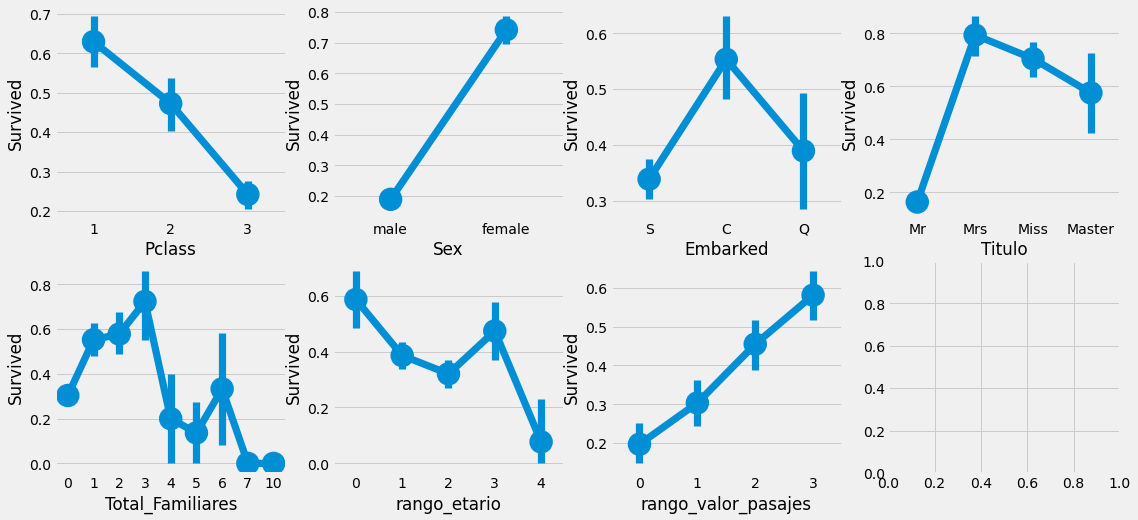

In [379]:
columnas_categoricas = ['Pclass', 'Sex', 'Embarked', 'Titulo',
       'Total_Familiares', 'rango_etario', 'rango_valor_pasajes']


f,ax= plt.subplots(2,4,figsize=(17,8))
sns.pointplot(data=df,x='Pclass', y='Survived', ax=ax[0,0])
sns.pointplot(data=df,x='Sex', y='Survived', ax=ax[0,1])
sns.pointplot(data=df,x='Embarked', y='Survived', ax=ax[0,2])
sns.pointplot(data=df,x='Titulo', y='Survived', ax=ax[0,3])
sns.pointplot(data=df,x='Total_Familiares', y='Survived',  ax=ax[1,0])
sns.pointplot(data=df,x='rango_etario', y='Survived', ax=ax[1,1])
sns.pointplot(data=df,x='rango_valor_pasajes', y='Survived', ax=ax[1, 2])

In [380]:
df['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
df['Titulo'].replace(['Mr','Mrs','Miss','Master'], [0,1,2,3],inplace=True)
df["Sex"].replace(["male","female"],[0,1], inplace = True )
df.drop("Sexo", axis=1,inplace=True)

Paso a calcular como varia la supervivencia en funcion a cada una de las variables de forma independiente:

In [381]:
# Lista de columnas para las cuales deseas calcular la tasa de supervivencia
columnas_tasa_supervivencia = ['Pclass', 'Sex', 'Embarked', 'Titulo', 'Total_Familiares', 'rango_etario', 'rango_valor_pasajes']

# Calcular y mostrar la tasa de supervivencia para cada columna
for columna in columnas_tasa_supervivencia:
    tasa_supervivencia_por_columna = df.groupby(columna)['Survived'].mean()
    print(f"Tasa de supervivencia en función de '{columna}':")
    print(tasa_supervivencia_por_columna)
    print()

Tasa de supervivencia en función de 'Pclass':
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Tasa de supervivencia en función de 'Sex':
Sex
0    0.188908
1    0.742038
Name: Survived, dtype: float64

Tasa de supervivencia en función de 'Embarked':
Embarked
0    0.339009
1    0.553571
2    0.389610
Name: Survived, dtype: float64

Tasa de supervivencia en función de 'Titulo':
Titulo
0    0.163265
1    0.793651
2    0.704301
3    0.575000
Name: Survived, dtype: float64

Tasa de supervivencia en función de 'Total_Familiares':
Total_Familiares
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

Tasa de supervivencia en función de 'rango_etario':
rango_etario
0    0.586207
1    0.385827
2    0.320359
3    0.473684
4    0.076923
Name: Survived, dtype: float64

Tasa de supervivencia en función de 'rango_valor_pasajes':
rango_valor_pasajes
0    0.1

# Armado de Heatmap:
    
Una vez categorizada las variables continuas armo el heatmap para ver la correlacion de todas las variables a utilizar en mi modelo predictivo de clasificacion

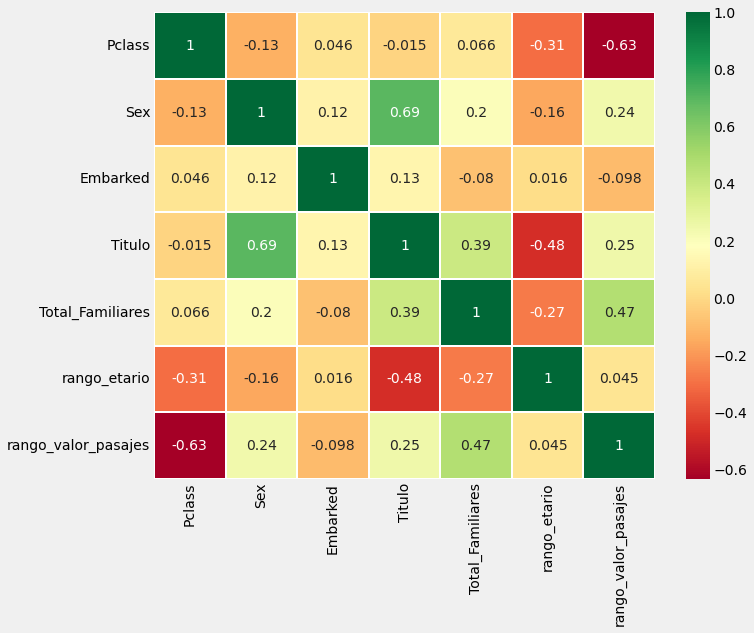

In [382]:
columnas_correlacion = ['Pclass', 'Sex', 'Embarked', 'Titulo',
       'Total_Familiares', 'rango_etario', 'rango_valor_pasajes']

# Calcular la matriz de correlación
matriz_correlacion = df[columnas_correlacion].corr()

sns.heatmap(matriz_correlacion,annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Todas las variables a utilizar tiene un grado de correlacion menor a 0,95 por lo cual no puedo descartar ninguna. Cada variable va a contribuir de forma diferente para predecir el resultado.

# Evaluacion de modelos de clasificacion:

Utilizando las variables de 'Pclass', 'Sex', 'Embarked', 'Titulo','Total_Familiares', 'rango_etario', 'rango_valor_pasajes". Procedo a hacer la evaluacion del desempeño de un modelo de clasificacion.

Separo mi data labeleada en "entry_modelo" para poder ver la capacidad predictiva del modelo
Con el "Entry modelo" lo que voy a hacer es separarlo en dos para tener infromacion de verdad a campo para ver como se desempeña el modelo elegido.

In [383]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

X_train = train[['Pclass', 'Sex', 'Embarked', 'Titulo', 'Total_Familiares','rango_etario', 'rango_valor_pasajes']]
Y_train = train["Survived"]
X_test = test [['Pclass', 'Sex', 'Embarked', 'Titulo', 'Total_Familiares','rango_etario', 'rango_valor_pasajes']]
Y_test_true = test["Survived"]


# Aplicacion de un modelo predictivo

Una vez separados y formateados ambos datasets para compatibilizarlos puedo elegir un modelo predictivo. Seleccionando alguno de los que vimos en la clase veo como es la capacidad predictiva del un modelo de "K-nearest neighbours".

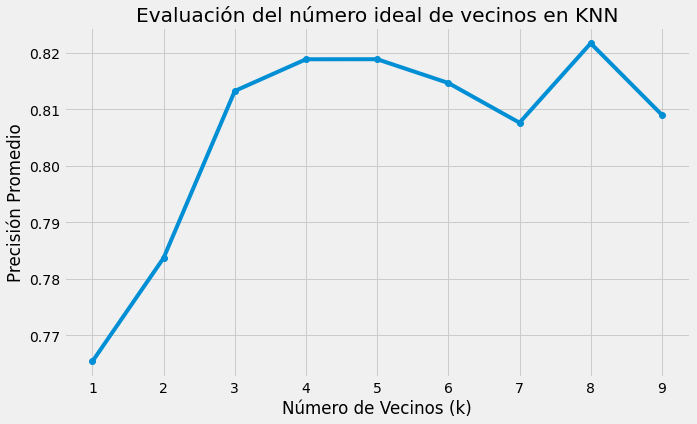

In [384]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Definir una lista de valores de k que deseas probar
k_values = list(range(1, 10))

# Inicializar listas para almacenar los resultados de la validación cruzada
cv_scores = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Precisión Promedio')
plt.title('Evaluación del número ideal de vecinos en KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [385]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
Y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0], dtype=int64)

In [386]:
accuracy = accuracy_score(Y_test_true, Y_pred)

# Calcular la precisión
precision = precision_score(Y_test_true, Y_pred)

# Calcular el recall
recall = recall_score(Y_test_true, Y_pred)

# Calcular el F1-score
f1 = f1_score(Y_test_true, Y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Accuracy: 0.79
Precisión: 0.77
Recall: 0.67
F1-score: 0.71


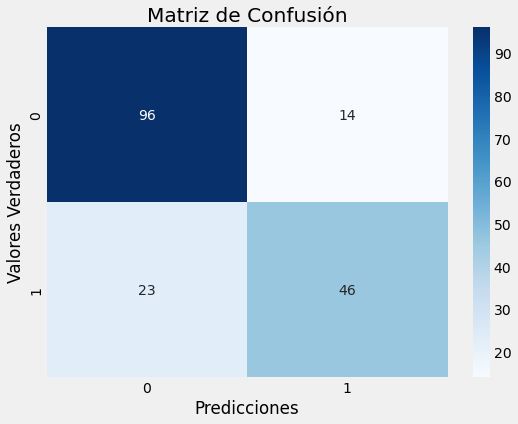

In [387]:
conf_matrix = confusion_matrix(Y_test_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Resultados con otro modelos de clasificacion

Paso a ver el accuracy de otros modelos de clasificacion para ver si otra metodologia tiene mejor poder predictivo. Los modelos a probar son:

Logistic Regression

Support Vector Machine

Random Forest


### Regresion logistica:

In [388]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Crear un modelo de regresión logística
logreg_model = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
logreg_model.fit(X_train, Y_train)

# Predecir las etiquetas para los datos de prueba
Y_pred = logreg_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test_true, Y_pred)

# Calcular la precisión
precision = precision_score(Y_test_true, Y_pred)

# Calcular el recall
recall = recall_score(Y_test_true, Y_pred)

# Calcular el F1-score
f1 = f1_score(Y_test_true, Y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 0.80
Precisión: 0.79
Recall: 0.65
F1-score: 0.71


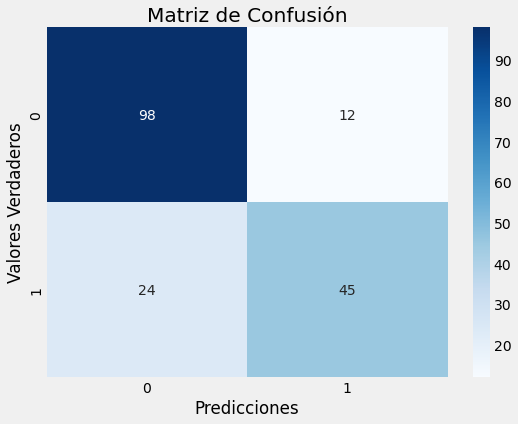

In [389]:
conf_matrix = confusion_matrix(Y_test_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

### Random Forest

In [390]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Crear un modelo Random Forest
rf_model = RandomForestClassifier()

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, Y_train)

# Predecir las etiquetas para los datos de prueba
Y_pred = rf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test_true, Y_pred)

# Calcular la precisión
precision = precision_score(Y_test_true, Y_pred)

# Calcular el recall
recall = recall_score(Y_test_true, Y_pred)

# Calcular el F1-score
f1 = f1_score(Y_test_true, Y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 0.82
Precisión: 0.78
Recall: 0.74
F1-score: 0.76


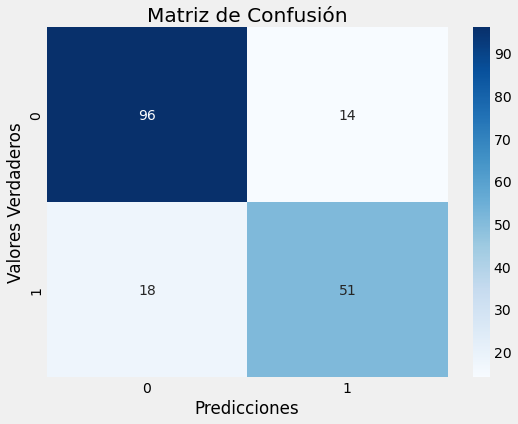

In [391]:
conf_matrix = confusion_matrix(Y_test_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

### Super vector machine (lineal)

In [392]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Crear un modelo SVM lineal
svm_linear_model = SVC(kernel='linear')

# Entrenar el modelo con los datos de entrenamiento
svm_linear_model.fit(X_train, Y_train)

# Predecir las etiquetas para los datos de prueba
Y_pred = svm_linear_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test_true, Y_pred)

# Calcular la precisión
precision = precision_score(Y_test_true, Y_pred)

# Calcular el recall
recall = recall_score(Y_test_true, Y_pred)

# Calcular el F1-score
f1 = f1_score(Y_test_true, Y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 0.77
Precisión: 0.70
Recall: 0.71
F1-score: 0.71


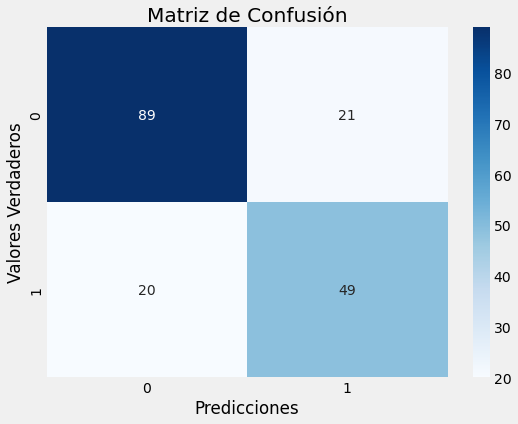

In [393]:
conf_matrix = confusion_matrix(Y_test_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

### Super Vector Machine Radial

In [394]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Crear un modelo SVM radial
svm_rbf_model = SVC(kernel='rbf')

# Entrenar el modelo con los datos de entrenamiento
svm_rbf_model.fit(X_train, Y_train)

# Predecir las etiquetas para los datos de prueba
Y_pred = svm_rbf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test_true, Y_pred)

# Calcular la precisión
precision = precision_score(Y_test_true, Y_pred)

# Calcular el recall
recall = recall_score(Y_test_true, Y_pred)

# Calcular el F1-score
f1 = f1_score(Y_test_true, Y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Accuracy: 0.83
Precisión: 0.81
Recall: 0.74
F1-score: 0.77


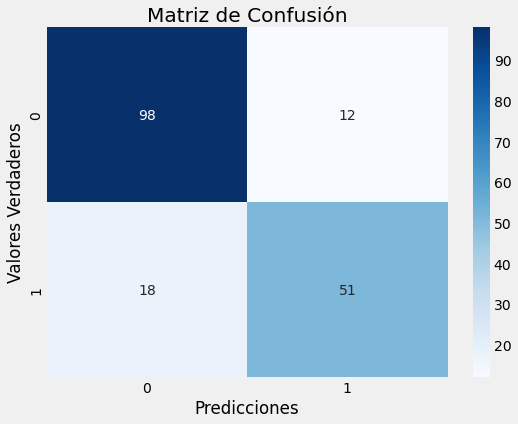

In [395]:
conf_matrix = confusion_matrix(Y_test_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

In [396]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Crear modelos de clasificación
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM Linear': SVC(kernel='linear', probability=True),
    'SVM Radial': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Inicializar un DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'], index=models.keys())

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, Y_train)
    
    # Predecir las etiquetas y las probabilidades para los datos de prueba
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    accuracy = accuracy_score(Y_test_true, Y_pred)
    precision = precision_score(Y_test_true, Y_pred)
    recall = recall_score(Y_test_true, Y_pred)
    f1 = f1_score(Y_test_true, Y_pred)
    roc_auc = roc_auc_score(Y_test_true, Y_prob)
    
    # Almacenar los resultados en el DataFrame
    results_df.loc[model_name] = [accuracy, precision, recall, f1, roc_auc]

# Mostrar el resumen
results_df


,Accuracy,Precision,Recall,F1-Score,ROC AUC
KNN,0.793296,0.766667,0.666667,0.713178,0.842688
Logistic Regression,0.798883,0.789474,0.652174,0.714286,0.868577
SVM Linear,0.77095,0.7,0.710145,0.705036,0.833267
SVM Radial,0.832402,0.809524,0.73913,0.772727,0.852503
Random Forest,0.782123,0.727273,0.695652,0.711111,0.859881
Decision Tree,0.804469,0.793103,0.666667,0.724409,0.789196


In [397]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

X_train = train[['Pclass', 'Sex', 'rango_etario','Embarked', 'Titulo', 'Total_Familiares', 'rango_valor_pasajes']]
Y_train = train["Survived"]
X_test = test [['Pclass', 'Sex', 'rango_etario', 'Embarked', 'Titulo', 'Total_Familiares', 'rango_valor_pasajes']]
Y_test_true = test["Survived"]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [398]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [399]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.33656758, 0.2487526 , 0.1687214 , 0.1124493 , 0.0782522 ,
       0.03081633, 0.02444058])

### Puedo ver que el mas del 85% de la varianza es explicado por las primeras 4 variables. Paso a evaluar como cambian las metricas utilizando solo estas variables.

In [400]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [401]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Crear modelos de clasificación
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM Linear': SVC(kernel='linear', probability=True),
    'SVM Radial': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Inicializar un DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'], index=models.keys())

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, Y_train)
    
    # Predecir las etiquetas y las probabilidades para los datos de prueba
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    accuracy = accuracy_score(Y_test_true, Y_pred)
    precision = precision_score(Y_test_true, Y_pred)
    recall = recall_score(Y_test_true, Y_pred)
    f1 = f1_score(Y_test_true, Y_pred)
    roc_auc = roc_auc_score(Y_test_true, Y_prob)
    
    # Almacenar los resultados en el DataFrame
    results_df.loc[model_name] = [accuracy, precision, recall, f1, roc_auc]

# Mostrar el resumen
results_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC
KNN,0.815642,0.775862,0.692308,0.731707,0.813765
Logistic Regression,0.793296,0.769231,0.615385,0.683761,0.842915
SVM Linear,0.793296,0.759259,0.630769,0.689076,0.833198
SVM Radial,0.804469,0.758621,0.676923,0.715447,0.794467
Random Forest,0.782123,0.703125,0.692308,0.697674,0.824157
Decision Tree,0.765363,0.688525,0.646154,0.666667,0.777733


En base a estos resultados puedo ver que el modelo con las mejores metricas es el de SVM Radial	

# K-fold cross validation y tuneo de Hiperparamentros

In [402]:
cv_results = []

for model_name, model in models.items():
    cv_results.append(cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=10))

cv_res = pd.DataFrame({
    'Algorithm': list(models.keys()),
    'Cross Validation Mean': [cv.mean() for cv in cv_results],
    'Cross Validation Std': [cv.std() for cv in cv_results]
})

cv_res.sort_values(by='Cross Validation Mean', ascending=False, ignore_index=True)


,Algorithm,Cross Validation Mean,Cross Validation Std
0,SVM Radial,0.825822,0.036905
1,SVM Linear,0.818760,0.036680
2,Logistic Regression,0.816002,0.037536
3,Random Forest,0.811757,0.035895
4,KNN,0.810407,0.042747
5,Decision Tree,0.790767,0.036169


Al aplicar esta metodologia de cross validation puedo ver que el modelo con el mejor accuracy es el de SVM radial. 

In [403]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, Y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.804 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.761 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.803 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.845 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.839 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.811 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.768 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.838 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.873 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.811 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.775 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.824 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.1s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.761 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.838 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.866 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.804 total time=   0.0s
[CV 3/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [404]:
print("Mejor combinacion de paramentros: ", grid.best_params_) 
print("Mejor CV score", grid.best_score_)

Mejor combinacion de paramentros:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Mejor CV score 0.8286417807544566


In [405]:
svc = SVC(C = 1, gamma = 0.1, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = accuracy_score(Y_test_true, Y_pred)
acc_svc



0.8100558659217877

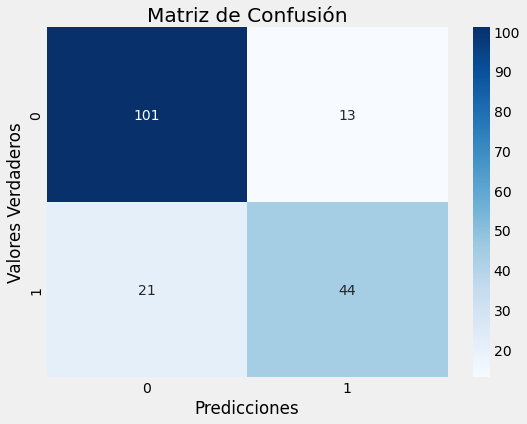

In [406]:
conf_matrix = confusion_matrix(Y_test_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

Puede verse que el accuracy aumenta haciendo un cross validation y un tuneo de los hiperparametros.

# Ensembling

Con el objetivo de mejorar el accuracy del modelo. Dentro de las tecnicas que se pueden aplicar existen:

    1)Bagging

    2)Boosting
    

Ene esta notebook voy a estar evaluando el accuarcy de un XGBClassifier.
    

In [407]:
import xgboost as xgb
df = df.astype(int)
X = df.drop("Survived", axis=1) #Elimino de mi dataset la variable a predecir
y = df.Survived #Defino el Target

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10,seed=42,max_depth=6, learning_rate=0.01)
clf_xgb.fit(X_train,y_train) #Entrenamos el modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [409]:
y_train_pred = clf_xgb.predict(X_train) #Prediccion en Train
y_test_pred = clf_xgb.predict(X_test) #Prediccion en Test

In [410]:
from sklearn.metrics import accuracy_score

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de train:',train_accuracy)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

#print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de train: 0.8384831460674157
% de aciertos sobre el set de evaluación: 0.8324022346368715


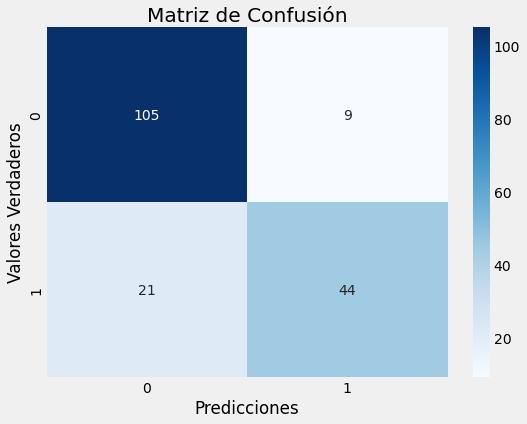

In [411]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Armado del dataset de test para el los resultados

Se hace el data wrangling del dataset de test que se va a usar para obtener los resultados de la competencia de Kaggle.

In [412]:
df2 = pd.read_csv("test.csv")
df2

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [413]:
df2["Titulo"]=df2['Name'].str.split(',').str[1].str.strip()
df2["Titulo"]=df2["Titulo"].str.split('.').str[0].str.strip()
df2["Titulo"]=df2["Titulo"].str.split(' ').str[0].str.strip()
df2["Titulo"].value_counts()

Titulo
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [414]:
missing_age=df2[["Titulo", "Age"]]
missing_age
listado=missing_age[missing_age['Age'].isnull()]
listado

,Titulo,Age
10,Mr,NaN
22,Mrs,NaN
29,Mr,NaN
33,Mrs,NaN
36,Miss,NaN
...,...,...
408,Miss,NaN
410,Miss,NaN
413,Mr,NaN
416,Mr,NaN


In [415]:
df2.loc[df2['Titulo'] == 'Ms', 'Titulo'] = 'Miss'

In [416]:
df2.groupby('Titulo')['Age'].mean()

Titulo
Col       50.000000
Dona      39.000000
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Rev       35.500000
Name: Age, dtype: float64

In [417]:
df2.loc[(df2["Age"].isnull()) & (df2["Titulo"]=='Mr'),'Age']=33
df2.loc[(df2["Age"].isnull()) & (df2["Titulo"]=='Mrs'),'Age']=37
df2.loc[(df2["Age"].isnull()) & (df2["Titulo"]=='Master'),'Age']=6
df2.loc[(df2["Age"].isnull()) & (df2["Titulo"]=='Miss'),'Age']=22


In [418]:
titulos_a_reemplazar = ['Capt', 'Col', 'Dr', "Major","Rev", "Sir", "the" ]
df2['Titulo'] = df2['Titulo'].replace(titulos_a_reemplazar, 'Mr')

titulos_a_reemplazar_2 = ["Lady", "Dona"]
df2['Titulo'] = df2['Titulo'].replace(titulos_a_reemplazar_2, 'Mrs')

In [419]:
df2.drop(columns=["Cabin", "Ticket", "Name"], inplace = True)
df2

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titulo
0,892,3,male,34.5,0,0,7.8292,Q,Mr
1,893,3,female,47.0,1,0,7.0000,S,Mrs
2,894,2,male,62.0,0,0,9.6875,Q,Mr
3,895,3,male,27.0,0,0,8.6625,S,Mr
4,896,3,female,22.0,1,1,12.2875,S,Mrs
...,...,...,...,...,...,...,...,...,...
413,1305,3,male,33.0,0,0,8.0500,S,Mr
414,1306,1,female,39.0,0,0,108.9000,C,Mrs
415,1307,3,male,38.5,0,0,7.2500,S,Mr
416,1308,3,male,33.0,0,0,8.0500,S,Mr


In [420]:
df2 = df2.dropna(subset=['Fare'])

In [421]:
df3 = df2.copy()

In [422]:
df2['Fare_log_norm'] = np.log1p(df2['Fare'])

<ipython-input-422-672b3b5f0817>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Fare_log_norm'] = np.log1p(df2['Fare'])


In [423]:
df2["Total_Familiares"]=df2["SibSp"]+df2["Parch"]

<ipython-input-423-aeffe4f9dc2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Total_Familiares"]=df2["SibSp"]+df2["Parch"]


In [424]:
df2.drop(["SibSp","Parch", "PassengerId","Fare"],axis=1,inplace = True)
df2

<ipython-input-424-0a46c102941b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(["SibSp","Parch", "PassengerId","Fare"],axis=1,inplace = True)


,Pclass,Sex,Age,Embarked,Titulo,Fare_log_norm,Total_Familiares
0,3,male,34.5,Q,Mr,2.178064,0
1,3,female,47.0,S,Mrs,2.079442,1
2,2,male,62.0,Q,Mr,2.369075,0
3,3,male,27.0,S,Mr,2.268252,0
4,3,female,22.0,S,Mrs,2.586824,2
...,...,...,...,...,...,...,...
413,3,male,33.0,S,Mr,2.202765,0
414,1,female,39.0,C,Mrs,4.699571,0
415,3,male,38.5,S,Mr,2.110213,0
416,3,male,33.0,S,Mr,2.202765,0


In [425]:
df2['Age'] = df2['Age'].astype(int)

<ipython-input-425-bff64920d7cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Age'] = df2['Age'].astype(int)


In [426]:
pd.cut(df2['Age'], bins=5)
categorias= [0,1,2,3,4]
df2["rango_etario"]=pd.cut(df2['Age'], bins=5, labels=categorias, right=False)
pd.qcut(df2['Fare_log_norm'], 4)
categorias= [0,1,2,3]
df2["rango_valor_pasajes"]=pd.qcut(df2['Fare_log_norm'], 4, labels=categorias)
df2

<ipython-input-426-bbb634269431>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["rango_etario"]=pd.cut(df2['Age'], bins=5, labels=categorias, right=False)
<ipython-input-426-bbb634269431>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["rango_valor_pasajes"]=pd.qcut(df2['Fare_log_norm'], 4, labels=categorias)


,Pclass,Sex,Age,Embarked,Titulo,Fare_log_norm,Total_Familiares,rango_etario,rango_valor_pasajes
0,3,male,34,Q,Mr,2.178064,0,2,0
1,3,female,47,S,Mrs,2.079442,1,3,0
2,2,male,62,Q,Mr,2.369075,0,4,1
3,3,male,27,S,Mr,2.268252,0,1,1
4,3,female,22,S,Mrs,2.586824,2,1,1
...,...,...,...,...,...,...,...,...,...
413,3,male,33,S,Mr,2.202765,0,2,1
414,1,female,39,C,Mrs,4.699571,0,2,3
415,3,male,38,S,Mr,2.110213,0,2,0
416,3,male,33,S,Mr,2.202765,0,2,1


In [427]:
df2.drop(["Fare_log_norm","Age"], axis=1,inplace=True)
df2['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
df2['Titulo'].replace(['Mr','Mrs','Miss','Master'], [0,1,2,3],inplace=True)
df2["Sex"].replace(["male","female"],[0,1], inplace = True )
df2 = df2.astype(int)

<ipython-input-427-9166d60d06da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(["Fare_log_norm","Age"], axis=1,inplace=True)
<ipython-input-427-9166d60d06da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
<ipython-input-427-9166d60d06da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Titulo'].replace(['Mr','Mrs','Miss','Master'], [0,1,2,3],inplace=True)
<i

# Armo mi Dataset con predicciones para la competencia de Kaggle

In [428]:
X_train = df.drop('Survived', axis = 1)
Y_train = df['Survived']
X_test = df2.copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (891, 7)
Y_train shape:  (891,)
X_test shape:  (417, 7)


In [429]:
svc = SVC(C = 1, gamma = 0.1, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
Y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [430]:
Prediccion = pd.DataFrame({'PassengerId': df3['PassengerId'], 'Survived': Y_pred})
Prediccion.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Descargando el siguiente datafrmae en un csv y bajo el actual formato, puedo presentar los resultados de mi modelo predictivo con el fin de ser evaluados en la competencia de Kaggle.